<a href="https://colab.research.google.com/github/ricadall/Stock-Market-ML-Analysis/blob/main/ITP449_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import statements
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.impute import KNNImputer
from sklearn.metrics import (
    classification_report,
    recall_score,
    precision_score,
    accuracy_score
)
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

# Dataset

## Dataset Description

For this analysis I will be the "200+ Financial Indicators of US stocks (2018)" dataset from Kaggle (https://www.kaggle.com/cnic92/200-financial-indicators-of-us-stocks-20142018)

This dataset contains data from the 2018 US Stock Market. It contains 200+ financial indicators that are commonly found in the 10-K filings each publicly traded company releases yearly, for a over 4k stocks. The last column, "class", lists a binary classification for each stock. If the class = 1 then the percent price variation of the stock went up following that year; if the class = 0 then the percent price variation of the stock went down following that year. This "class" column has be used a a measure of whether or not the stock is worth buying. 

### Importing the dataset

I will be importing this dataset in two parts: one with the numerical data and one with string data. I am doing this to ensure I can import the numerical data as a float32 because I had trouble with my analysis when the dataset imported as a float64 because the size was too large.

  **Importing Numerical Data:**

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving 2018_Financial_Datacopy2.csv to 2018_Financial_Datacopy2 (1).csv


In [ ]:
num_df = pd.read_csv('2018_Financial_Datacopy2.csv').astype(np.float32)
num_df.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class
0,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,0.1599,0.1241,3.814000e+09,0.000000e+00,3.814000e+09,1.110400e+10,0.000000e+00,2.184800e+10,4.443700e+10,1.676230e+11,7.883000e+09,...,0.000000,9.4801,3.6159,0.000000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,1.0
1,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,0.000000e+00,3.280000e+09,1.498000e+09,3.850000e+08,5.722000e+09,3.789700e+10,2.484500e+10,7.481000e+09,...,-19.281700,9.6022,2.8248,34.966599,0.0478,-1.3195,0.0564,0.0405,0.0751,53.851898,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,1.0
2,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,0.3291,0.2972,3.019000e+09,8.631000e+09,1.165000e+10,6.722000e+09,7.253000e+09,2.878700e+10,4.897600e+10,3.634900e+10,9.430000e+09,...,-97.648399,11.4929,5.5264,9.953400,0.2824,-3.2923,0.1187,0.1203,0.2917,1.192800,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,1.0
3,3.039100e+10,0.4955

**Importing String Data:**

In [ ]:
from google.colab import files 
uploaded = files.upload()

Saving sectors.numbers to sectors.numbers


In [ ]:
sec_df = pd.read_csv('sectors.csv')
sec_df2 = pd.read_csv('sectors.csv')
sec_df.head()

,Sector
0,Consumer Cyclical
1,Energy
2,Technology
3,Technology
4,Industrials


Now that both datasets have been imported in the desired form; I will be combining them to create the dataframe I will be working with for the analysis.

In [ ]:
df = pd.concat([num_df, sec_df], axis=1)
df.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class,Sector
0,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,0.1599,0.1241,3.814000e+09,0.000000e+00,3.814000e+09,1.110400e+10,0.000000e+00,2.184800e+10,4.443700e+10,1.676230e+11,7.883000e+09,...,9.4801,3.6159,0.000000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,1.0,Consumer Cyclical
1,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,0.000000e+00,3.280000e+09,1.498000e+09,3.850000e+08,5.722000e+09,3.789700e+10,2.484500e+10,7.481000e+09,...,9.6022,2.8248,34.966599,0.0478,-1.3195,0.0564,0.0405,0.0751,53.851898,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,1.0,Energy
2,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,0.3291,0.2972,3.019000e+09,8.631000e+09,1.165000e+10,6.722000e+09,7.253000e+09,2.878700e+10,4.897600e+10,3.634900e+10,9.430000e+09,...,11.4929,5.5264,9.953400,0.2824,-3.2923,0.1187,0.1203,0.2917,1.192800,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,1.0,Technology
3,3.039100e+10,0.4955,1.250000e+10,

## Dataset Overview

I will now be exploring the data to to inform which type of model to choose to analyze this dataset.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Columns: 223 entries, Revenue to Sector
dtypes: float32(222), object(1)
memory usage: 3.8+ MB


In [ ]:
df.describe()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class
count,4.346000e+03,4253.000000,4.207000e+03,4.328000e+03,4.155000e+03,4.226000e+03,4.208000e+03,4.357000e+03,4.208000e+03,4.321000e+03,4.252000e+03,4.142000e+03,4.142000e+03,4.241000e+03,4.142000e+03,4.275000e+03,4327.000000,4329.000000,4.326000e+03,4.192000e+03,4142.000000,4341.000000,4084.000000,4218.000000,4086.000000,4138.000000,4.209000e+03,4.249000e+03,4.241000e+03,4341.000000,4216.000000,4.343000e+03,4.213000e+03,4.273000e+03,4.354000e+03,4.195000e+03,4.207000e+03,4.223000e+03,4.250000e+03,4.211000e+03,...,4.156000e+03,4260.000000,3914.000000,4153.000000,4.136000e+03,4.141000e+03,4267.000000,4144.000000,4283.000000,4162.000000,4261.000000,4.267000e+03,4117.000000,4210.000000,4129.000000,4250.000000,4129.000000,2739.000000,3543.000000,3960.000000,2746.000000,3551.000000,3961.000000,2739.000000,3543.000000,3960.000000,2697.000000,3509.000000,3960.000000,2810.000000,3684.000000,4067.000000,4268.000000,4160.000000,4178.000000,4121.000000,4128.000000,4133.000000,4144.000000,4392.000000
mean,5.119291e+09,3.455280,3.144947e+09,2.043951e+09,1.180175e+08,9.005018e+08,1.435548e+09,6.541193e+08,1.001350e+08,5.584438e+08,1.228084e+08,1.521629e+07,-5.021774e+06,4.473249e+08,4.596720e+06,4.483769e+08,-69.937477,-71.428749,2.668512e+08,2.653561e+08,0.612978,0.497372,-7.943104,-4.823490,-8.255710,-4.624435,9.853866e+08,6.705078e+08,4.622582e+08,-4.691854,-4.820224,2.416297e+09,1.397532e+09,3.391311e+09,1.240592e+09,6.574195e+08,5.826573e+09,2.596666e+09,1.932811e+09,2.991717e+09,...,-1.481868e+03,21.398289,8.383671,48.044926,2.685087e+03,-1.635781e+04,2.085416,-1.687267,0.544212,1.424044,0.551279,9.299584e+03,54.641586,0.459741,0.136031,-5.267608,1.593211,0.015824,0.028731,0.049008,0.036428,0.046530,0.072548,0.038281,0.057213,0.083797,0.031093,0.028638,0.041146,-0.031246,-0.010214,0.006081,36.768520,0.183066,1.389013,0.262529,9.928448,0.091891,0.153610,0.693534
std,2.049508e+10,195.506561,1.508802e+10,7.682372e+09,9.330469e+08,3.661116e+09,5.529831e+09,2.969342e+09,3.780024e+08,2.639328e+09,7.349187e+08,1.539078e+08,1.847090e+08,2.118659e+09,4.601166e+07,2.103789e+09,5718.529785,5691.622070,2.025498e+09,2.034453e+09,1.452679,0.583203,182.556824,103.506699,185.013992,95.014687,3.863664e+09,2.78

In [ ]:
df.corr()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class
Revenue,1.000000,-0.003888,0.953780,0.814709,0.364756,0.701684,0.800147,0.640481,0.466732,0.651730,0.560934,0.420052,0.011648,0.622786,0.122968,0.624823,0.003692,0.004480,0.297157,0.298006,0.147623,-0.042783,0.012916,0.012050,0.013047,0.012380,0.751271,0.687306,0.636587,0.011763,0.011933,0.101177,0.144350,0.161816,0.159097,0.093123,0.267924,0.705415,0.407431,0.094404,...,0.003837,-0.000942,-0.007498,-0.002766,-0.003829,-0.038349,-4.126780e-03,0.003076,-0.003639,0.000215,0.016837,0.000656,-0.003890,-0.010580,0.004224,0.004977,0.015072,0.063390,0.029324,0.018958,0.048385,0.030378,0.004243,0.030925,0.031495,0.020885,0.058353,0.034467,0.016878,0.073395,0.056635,0.044995,-0.003803,-0.005479,-0.008657,-0.002757,-0.005846,-0.024754,-0.019629,0.074664
Revenue Growth,-0.003888,1.000000,-0.003486,-0.004545,-0.001548,-0.004131,-0.004348,-0.005424,-0.004540,-0.005608,-0.004349,-0.001695,0.000414,-0.004000,-0.001755,-0.003997,0.000198,0.000199,-0.002027,-0.002014,-0.007349,0.013496,0.000654,0.000400,0.000637,0.000592,-0.004552,-0.004437,-0.004053,0.000313,0.000319,-0.001301,-0.001284,-0.001627,-0.001300,-0.000730,-0.001777,-0.003983,-0.003494,-0.001100,...,0.000266,0.002459,-0.000953,-0.000532,-0.000104,0.000645,9.996045e-01,0.000245,-0.000831,-0.000401,-0.001087,-0.000267,-0.000276,0.000037,-0.000985,0.000074,-0.000454,-0.002063,-0.001653,0.002362,-0.006009,-0.003982,-0.003844,-0.006630,-0.004958,-0.003416,-0.045206,-0.017697,-0.003321,0.002598,0.000768,-0.000440,-0.000288,-0.000071,0.000861,0.000247,-0.000278,0.025981,0.001786,0.009091
Cost of Revenue,0.953780,-0.003486,1.000000,0.602664,0.255148,0.524652,0.606393,0.447391,0.388553,0.466087,0.414872,0.384208,0.010782,0.438346,0.033431,0.441447,0.002734,0.003883,0.237881,0.238541,0.123214,-0.075682,0.010623,0.009892,0.010751,0.010070,0.568906,0.496203,0.452536,0.009893,0.009818,0.068616,0.041361,0.061170,0.430795,0.096388,0.114679,0.637251,0.264384,0.043595,...,0.003555,-0.000569,-0.006564,-0.002257,-0.003159,-0.044282,-3.463918e-03,0.002395,-0.002852,0.000515,0.016180,0.001083,-0.003189,-0.008860,0.002702,0.004611,0.022224,0.052307,0.020727,0.014835,0.040611,0.027068,0.000298,0.010461,0.017103,0.011280,0.048941,0.023865,0.013844,0.068644,0.04171

In [ ]:
# code from the pandas website
corr = df.corr().abs()
s = corr.unstack()
so = s.sort_values(kind="quicksort")
print(so[-4470:-4460])

Operating Income                 Operating Cash Flow                0.277893
Operating Cash Flow              Operating Income                   0.277893
R&D to Revenue                   EV to Sales                        0.277982
EV to Sales                      R&D to Revenue                     0.277982
Weighted Average Shs Out         Operating Income                   0.278180
Operating Income                 Weighted Average Shs Out           0.278180
Effect of forex changes on cash  Free Cash Flow                     0.278256
Free Cash Flow                   Effect of forex changes on cash    0.278256
Property, Plant & Equipment Net  Total debt                         0.278483
Total debt                       Property, Plant & Equipment Net    0.278483
dtype: float64


## Exploration of Features

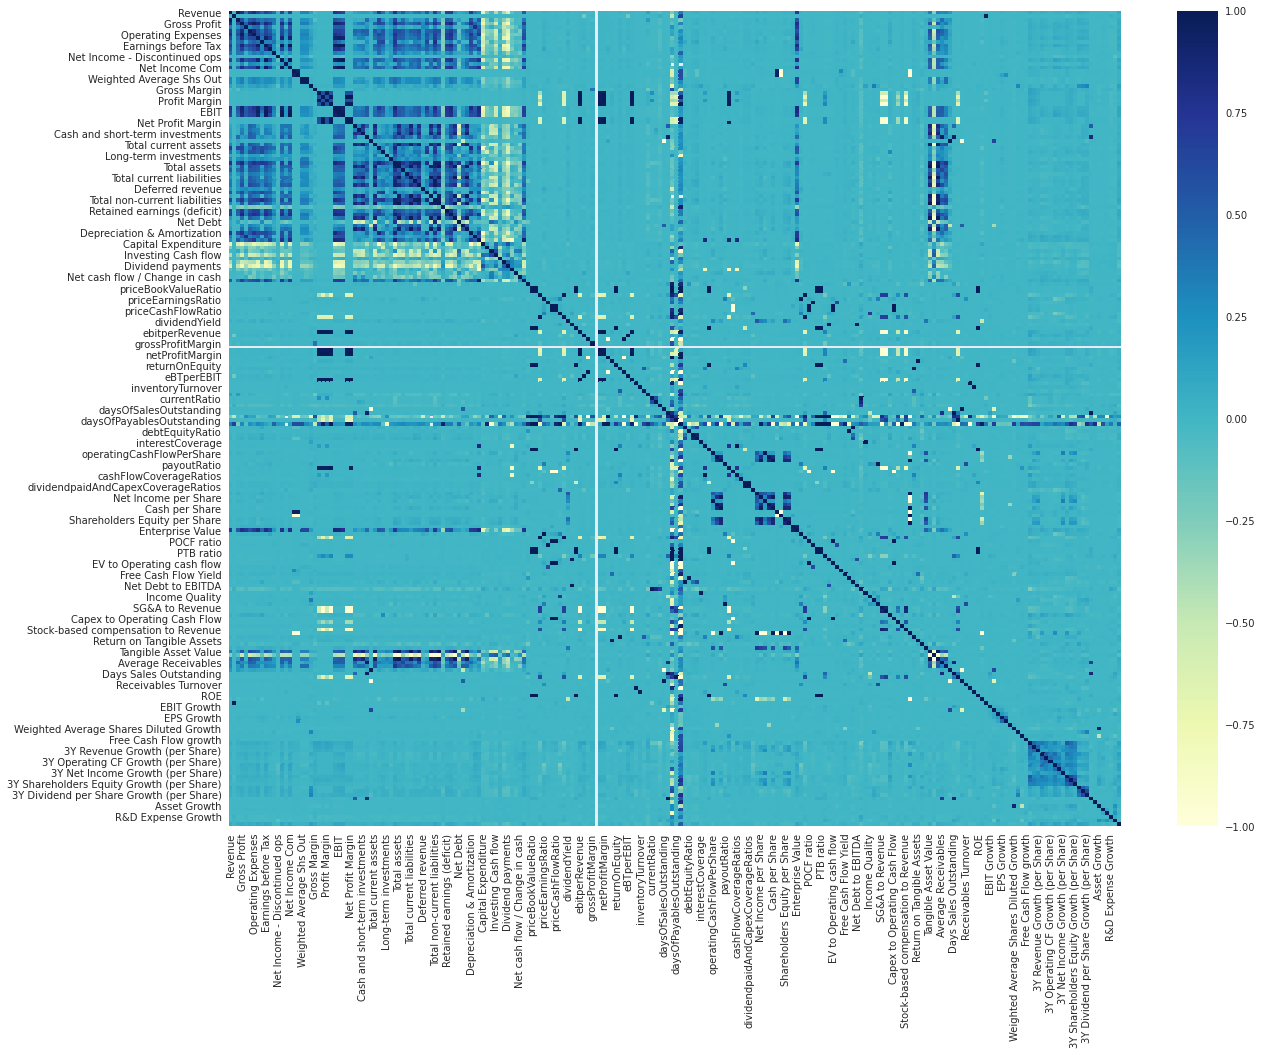

In [ ]:
fig, ax = plt.subplots(figsize=(20,15)) 
sns.heatmap(df.corr(), annot=False, cmap='YlGnBu', vmin=-1, vmax=1, center=0, ax=ax)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


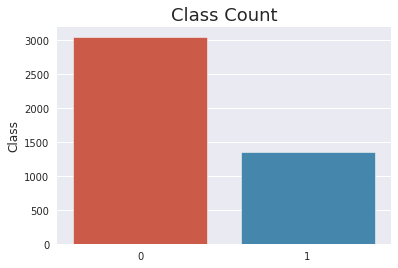

In [ ]:
classes = df['Class'].value_counts()
class_len = len(classes)
sns.set_style("darkgrid")
sns.barplot(np.arange(class_len), classes)
plt.title('Class Count', fontsize=18)
plt.show()

In [ ]:
print("Number of null values in 'Class':", df['Class'].isnull().sum())

Number of null values in 'Class': 0


This exploration reveals two main findings:

1. This dataset has a large number of features (223) and entries (4392) and as such I will select models that are able to support this size of dataset

2. The "Class" feature is binary, It is either 0 or 1. If the class = 1 then the percent price variation of the stock went up following that year; if the class = 0 then the percent price variation of the stock went down following that year. This "class" column has be used a a measure of whether or not the stock is worth buying. It is also not missing for any row meaning that each stock has either a 0 or 1 value assigned to it. This means I can use a classification model for this dataset. 

Based on these findings, I will choose to analyze this dataset with classification models that are able to handle large datasets.

# Data Cleaning and Preparation

## Turning "Sectors" into Dummy Values

The "Sector" feature describes what sector the company is part of; for example: healthcare, technology, energy, real estate, etc. To be able to intergrate the "Sector" feature in my model, I will be converting this column into dummy values so the String data can be converted into numerical data.

In [ ]:
dummy = pd.get_dummies(df['Sector'])
dummy.head()

,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,0


I can now drop the original "Sector" feature from the dataframe and replace it with the new dummy values columns.

In [ ]:
df = df.drop('Sector', axis=1)

In [ ]:
df1 = pd.concat([dummy, df], axis=1)
df1.head()

,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class
0,0,0,1,0,0,0,0,0,0,0,0,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,...,0.000000,9.4801,3.6159,0.000000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,1.0
1,0,0,0,0,1,0,0,0,0,0,0,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,...,-19.281700,9.6022,2.8248,34.966599,0.0478,-1.3195,0.0564,0.0405,0.0751,53.851898,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,1.0
2,0,0,0,0,0,0,0,0,0,1,0,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,...,-97.648399,11.4929,5.5264,9.953400,0.2824,-3.2923,0.1187,0.1203,0.2917,1.192800,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,1.0
3,0,0,0,0,0,0,0,0,0,1,0,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,1.680000e+08,3000000.0,0.000000e+00,1.413500e+10,0.0,1.413500e+10,12.27,11.51,1.159811e+09,1.152000e+09,0.000,0.5887,0.638,0.4819,0.465,0.2804,1.940400e+10,1.464500e+10,1.413800e+10,...,-104.973999,6.5803,2.1000,9.047600,0.4377,-7.7075,1.1208,1.5233,1.5552,1.777600,1.6274,1.6100,0.0579,0.0650,0.0000

Now that the dataframe is complete, I can now handle any missing values.

## Handling missing values

First, I will check if and/or how many missing values this dataset contains. 

In [ ]:
print("Total number of null values:", df1.isnull().sum(axis = 1).sum())

Total number of null values: 97298


To get an overview of the distribution of the missing values, I will use a heatmap.

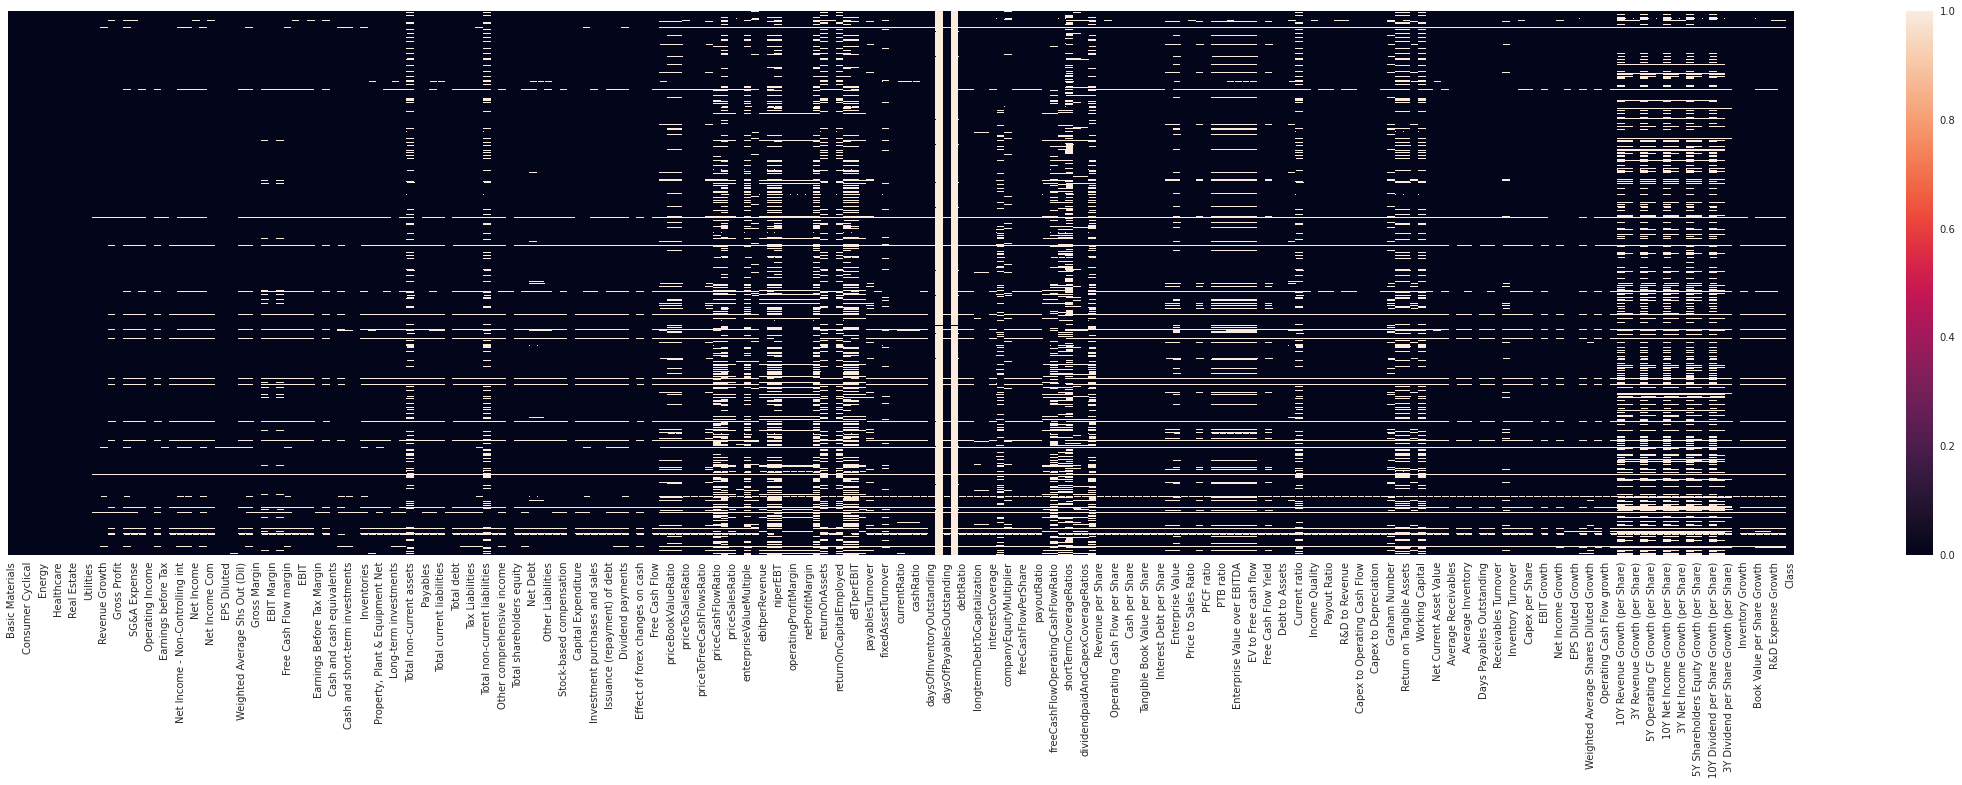

In [ ]:
plt.figure(figsize = (40,10))
sns.heatmap(df1.isnull(), yticklabels=False)

From the heatmap, I can already see that there are features who have extremely high percentages of missing values. To see which features have the most missing values and whether or not this percentage of missing values is high enough to merit removing the feature, I will sum the null values of each feature, place this data in a dataframe, sort the dataframe in descending order and print the first 20 values. I will also find the percentage of null values of these features. This will allow me to see the features with the highest percentage of missing values and what this percetnage is.

In [ ]:
col_len = df1.shape[0]
null_df = df1.isnull().sum().sort_values(ascending=False).head(20)
null_df = null_df.to_frame()
null_df.rename(columns={0:"Null Count"}, inplace=True)
null_df['Percentage Null'] = ((null_df["Null Count"] / col_len)*100)
print(null_df)

                                            Null Count  Percentage Null
cashConversionCycle                               4386        99.863388
operatingCycle                                    4386        99.863388
shortTermCoverageRatios                           1926        43.852459
10Y Shareholders Equity Growth (per Share)        1695        38.592896
priceEarningsToGrowthRatio                        1658        37.750455
dividendPayoutRatio                               1658        37.750455
10Y Revenue Growth (per Share)                    1653        37.636612
10Y Net Income Growth (per Share)                 1653        37.636612
10Y Operating CF Growth (per Share)               1646        37.477231
10Y Dividend per Share Growth (per Share)         1582        36.020036
nIperEBT                                          1561        35.541894
niperEBT                                          1561        35.541894
effectiveTaxRate                                  1561        35

The features "cashConversionCycle" and "operatingCycle" have a very high percetnage of null values. It is recommended to remove any feature that has more than 70-75% missing values; since these two columns have more than a 99% null values, they will be removed.

In [ ]:
df1 = df1.drop('cashConversionCycle', axis=1)
df1 = df1.drop('operatingCycle', axis=1)

In [ ]:
df1.head()

,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class
0,0,0,1,0,0,0,0,0,0,0,0,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,...,0.000000,9.4801,3.6159,0.000000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,1.0
1,0,0,0,0,1,0,0,0,0,0,0,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,...,-19.281700,9.6022,2.8248,34.966599,0.0478,-1.3195,0.0564,0.0405,0.0751,53.851898,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,1.0
2,0,0,0,0,0,0,0,0,0,1,0,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,...,-97.648399,11.4929,5.5264,9.953400,0.2824,-3.2923,0.1187,0.1203,0.2917,1.192800,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,1.0
3,0,0,0,0,0,0,0,0,0,1,0,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,1.680000e+08,3000000.0,0.000000e+00,1.413500e+10,0.0,1.413500e+10,12.27,11.51,1.159811e+09,1.152000e+09,0.000,0.5887,0.638,0.4819,0.465,0.2804,1.940400e+10,1.464500e+10,1.413800e+10,...,-104.973999,6.5803,2.1000,9.047600,0.4377,-7.7075,1.1208,1.5233,1.5552,1.777600,1.6274,1.6100,0.0579,0.0650,0.0000

Now, I will see how many null values I still have left.

In [ ]:
df1.isnull().sum(axis = 1).sum()

88526

This is still a large number of null values left; however I have already removed the features who had a large enough missing value percentage to merit being removed. Since removing more features is not the best option, I will instead use Scikit-learn KNNImputer which uses the k-Nearest Neighbors method to fill missing values.

In [ ]:
imputer = KNNImputer(n_neighbors=2)
df_filled = imputer.fit_transform(df1)

I will now fit the results to a new dataframe.

In [ ]:
print(df_filled)

[[ 0.      0.      1.     ...  0.      0.1308  1.    ]
 [ 0.      0.      0.     ...  0.     -0.1265  1.    ]
 [ 0.      0.      0.     ...  0.039  -0.0942  1.    ]
 ...
 [ 1.      0.      0.     ...  0.2415  0.8987  0.    ]
 [ 0.      0.      0.     ...  2.7499  0.1457  0.    ]
 [ 0.      0.      0.     ...  0.3577  0.588   1.    ]]


In [ ]:
df1 = pd.DataFrame(df_filled, columns=df1.columns)
df1.head()

,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Class
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,...,0.000000,9.4801,3.6159,0.000000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.484000,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.19280,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,1.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,...,-19.281700,9.6022,2.8248,34.966599,0.0478,-1.3195,0.0564,0.0405,0.0751,53.851898,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,-0.0115,-0.1402,-0.0104,0.0397,-0.1057,-0.0215,0.03585,-0.0881,0.8445,0.0554,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,...,-97.648399,11.4929,5.5264,9.953400,0.2824,-3.2923,0.1187,0.1203,0.2917,1.192800,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.17190,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,1.680000e+08,3000000.0,0.000000e+00,1.413500e+10,0.0,1.413500e+10,12.27,11.51,1.159811e+09,1.152000e+09,0.000,0.5887,0.638,0.4819,0.465,0.2804,1.940400e+10,1.464500e+10,1.413800e+10,...,-104.97399

Now, I will ensure that my dataframe has no null values.

In [ ]:
df1.isnull().sum().sort_values(ascending=False).head(20)

Class                              0
Net Cash/Marketcap                 0
Net cash flow / Change in cash     0
Effect of forex changes on cash    0
Financing Cash Flow                0
Dividend payments                  0
Issuance (buybacks) of shares      0
Issuance (repayment) of debt       0
Investing Cash flow                0
Investment purchases and sales     0
Acquisitions and disposals         0
Capital Expenditure                0
Operating Cash Flow                0
Stock-based compensation           0
Depreciation & Amortization        0
Other Liabilities                  0
Other Assets                       0
Net Debt                           0
Investments                        0
Total shareholders equity          0
dtype: int64

All missing values have been filled and as such I am ready to begin fiting this data to models.

# Models

In [ ]:
X = df1.drop('Class',axis=1)
y = df1.loc[:,'Class'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

### Decision Tree

**Justification for use of Decision Tree:**

I have selected the Decision Tree as one of my models due to its ability to use different feature subsets and decision rules at different stages of classification. Though Decision Tree are commonly prone to overfitting, I will use pruning to hopefully mitigate this. 


**Decision tree before pruning**

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy')
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc_testing = accuracy_score(y_pred, y_test)
print("Accuracy = ",acc_testing)

Accuracy =  0.6482758620689655


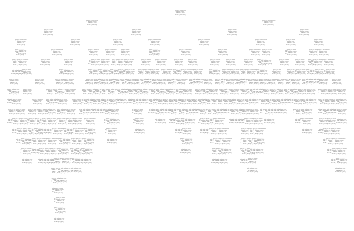

In [ ]:
plt.figure(2)
stockTree = tree.plot_tree(dt)
plt.show()

**Decision tree after pruning**

In [ ]:
dt = DecisionTreeClassifier(criterion='entropy', random_state=0, max_depth=10)
dt.fit(X_train, y_train)
y_pred = dt.predict(X_test)
acc_testing = accuracy_score(y_pred, y_test)
print("Accuracy = ",acc_testing)

Accuracy =  0.6820689655172414


Evidently, the pruning has increased the accuracy of the model and printing the tree will reveal that the max depth did indeed get smaller.

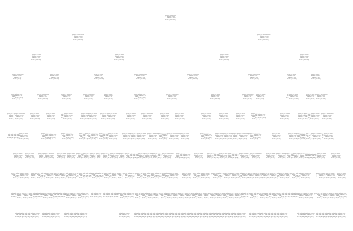

In [ ]:
plt.figure(2)
stockTree = tree.plot_tree(dt)
plt.show()

### Random Forest model

**Justification for use of Random Forest Model:**

Random Forest Models are known to handle large amounts of data well which is benefical for this analysis as the dataset is quite large. They are also less prone to overfitting in classification as they consider only a subset of features and the final outcome of the model is dependent on all trees.


In [ ]:
from sklearn.metrics import recall_score
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)
predict_rf = model_rf.predict(X_test)
recall_rf = recall_score(y_test, predict_rf, pos_label=1.0)
precision_rf = precision_score(y_test, predict_rf, pos_label=1.0)

print(' Accuracy = ', precision_rf)

 Accuracy =  0.7627551020408163


### Logistic Regression

**Justification for use of Logistic Regression:**

I have selected Logistic Regression as one my models due to its effectiveness in classification and because of how simple it is to implement. Unfortunately, this dataset is larger than commonly used for Logistic Regression but I can make my model accomudate this my increasing "Max_iter". I will also be using L2 regularization to help prevent overfitting.

In [ ]:
model = LogisticRegression(max_iter=500000000, penalty='l2', solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
log_acc = accuracy_score(y_test, y_pred)
print('Accuracy =', log_acc)

Accuracy = 0.6793103448275862


### XGBoost

**Justification for use of XGBoost:**

I have selected a XGBoost Classifier as one of my models for a variety of reasons:

- it is known to have excellent speed and performance
- it has a wide variety of tuning parameters
- its core algorithm is parallelizable
- it has shown better performance on a variety of machine learning benchmark datasets than other ML methods

In [ ]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(objective="binary:logistic", random_state=2020, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)

xgb_acc = accuracy_score(y_test, y_pred)
print("Accuracy = ", xgb_acc )

Accuracy =  0.7282758620689656


## Bagging Classifier

**Justification for use of Bagging Classifier:**

Much of my models use Decision Tree Classifiers. Decision Tree Classifiers are prove to overfitting. Additionally, Decision Trees are often unstable, meaning even a very small change in the training data can result in a very different Decision Tree model.

However, according to our class notes: "a tree based Bagging ensemble takes advantage of these shortcomings by fitting each tree on a different bootstrap sample of the training data. Due to the unstable nature of Decision Trees, overfitting each tree to its particular bootstrapped sample will result in an ensemble with a diverse set of trees. While each individual tree is overfit to the data it was trained with, the variance of the overall ensemble is reduced due to this diverse set of trees."

In [ ]:
model_bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators = 10, random_state = 42)
model_bagging.fit(X_train, y_train)
pred_bagging = model_bagging.predict(X_test)
bagging_acc = accuracy_score(y_test, pred_bagging)

print(' Accuracy = ', bagging_acc)

 Accuracy =  0.6841379310344827


## Voting Ensemble

**Justification for use of Voting Ensemble:**

I have selected Voting Ensemble as one of my models as this model combines the predictions of multiple models to make its predictions and thereby helps increase the accuracy of the predictions.

In [ ]:
# Voting Ensemble for Classification
# Enter your code here
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

rfClf = RandomForestClassifier(max_depth = 10, n_estimators=200, random_state=0) 
dtcClf = DecisionTreeClassifier(max_depth = 10)
logClf = LogisticRegression(max_iter=500000000, penalty='l2', solver='liblinear')
xgbClf = XGBClassifier()


clf2 = VotingClassifier(estimators = [('rf',rfClf), ('dt',dtcClf), ('xgb',xgbClf), ('log', logClf)], voting='soft') 
clf2.fit(X_train, y_train)

clf2_pred = clf2.predict(X_test)
recall_voting = recall_score(y_test, clf2_pred, average="binary", pos_label=1.0)
precision_voting = precision_score(y_test, clf2_pred, pos_label=1.0)
vote_acc = accuracy_score(y_test, clf2_pred)
print('Accuracy score', vote_acc)

Accuracy score 0.7151724137931035


# Conclusion

## Model Selection

To compare the accuracy of each classifier and deduce the most accuracte one, I will plot each classifier accuracy on a barplot with labels.

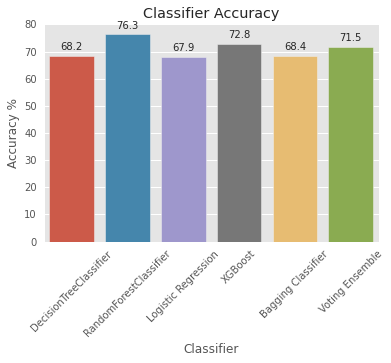

In [ ]:
plt.style.use('ggplot')
data = {'Classifier':  ["DecisionTreeClassifier", "RandomForestClassifier", "Logistic Regression", "XGBoost", "Bagging Classifier", "Voting Ensemble"],
        'Acc': [acc_testing, precision_rf, log_acc, xgb_acc, bagging_acc, vote_acc ],
        }

for count, el in enumerate(data['Acc']):
  data['Acc'][count] = el * 100

acc_data = pd.DataFrame (data, columns = ['Classifier','Acc'])

g = sns.barplot(x='Classifier', y='Acc', data=acc_data)
plt.xticks(rotation=45)
plt.ylabel('Accuracy %')
plt.title('Classifier Accuracy')

for p in g.patches:
    g.annotate(format(p.get_height(), '.1f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.show()

The Random Forest Classifier has the highest accuracy % (76.3) followed by XGBosst (72.8) and the Voting Ensemble (71.5). To ensure the Random Forest Classifier is actaully the most promising model and has not simply been overfit I will perform a cross validation on each of these models.

**Cross validation of Random Forest Classifier**

In [ ]:
from sklearn.model_selection import cross_val_score
rfc_cv = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

rfc_cv_mean = scores.mean()

Scores: [0.70169492 0.75932203 0.68707483 0.74829932 0.74829932 0.72789116
 0.72789116 0.74829932 0.72108844 0.71768707]
Mean: 0.7287547561397442
Standard Deviation: 0.02175439554898717


**Cross validation of XGBoost Classifier**

In [ ]:
xgb_cv = XGBClassifier(objective="binary:logistic", random_state=2020, learning_rate=0.1)
scores = cross_val_score(xgb_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

xgb_cv_mean = scores.mean()

Scores: [0.72881356 0.71186441 0.68027211 0.74829932 0.73469388 0.7244898
 0.73469388 0.75170068 0.72108844 0.71428571]
Mean: 0.7250201775625504
Standard Deviation: 0.019395233783163452


**Cross validation of Voting Ensemble**

In [ ]:
rfClf = RandomForestClassifier(max_depth = 10, n_estimators=200, random_state=0) 
dtcClf = DecisionTreeClassifier(max_depth = 10)
logClf = LogisticRegression(max_iter=500000000, penalty='l2', solver='liblinear')
xgbClf = XGBClassifier()

clf2 = VotingClassifier(estimators = [('rf',rfClf), ('dt',dtcClf), ('xgb',xgbClf), ('log', logClf)], voting='soft')

vote_cv = XGBClassifier(objective="binary:logistic", random_state=2020, learning_rate=0.1)
scores = cross_val_score(vote_cv, X_train, y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

vote_cv_mean = scores.mean()

Scores: [0.72881356 0.71186441 0.68027211 0.74829932 0.73469388 0.7244898
 0.73469388 0.75170068 0.72108844 0.71428571]
Mean: 0.7250201775625504
Standard Deviation: 0.019395233783163452


**Comparison of cross validation scores between each model**

In [ ]:
data1 = {'Classifier':  ["RandomForestClassifier","XGBoost", "Voting Ensemble"],
        'Cross Validation Score': [rfc_cv_mean, xgb_cv_mean, vote_cv_mean],
        }

cv_data = pd.DataFrame (data1, columns = ['Classifier','Cross Validation Score'])

cv_data.sort_values(by='Cross Validation Score', ascending=False)


,Classifier,Cross Validation Score
0,RandomForestClassifier,0.728755
1,XGBoost,0.725020
2,Voting Ensemble,0.725020


The Random Forest Classifier has the highest cross validation score as well as having the highest accuracy; as such I will select it as my model.

## Model Fine Tuning

To fine-tune my model, I will be using Scikit-learn’s GridSearchCV to optimize my model’s hyperparameters.


In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_depth': [10, None],'n_estimators': [10, 50, 200],'random_state':[0, 42, None]}  
   
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 2,n_jobs=-1) 
   
grid.fit(X_train, y_train) 
grid_predictions = grid.predict(X_test) 
print(classification_report(y_test, grid_predictions)) 

print(grid.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   34.7s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:  2.0min finished


              precision    recall  f1-score   support

         0.0       0.62      0.35      0.45       441
         1.0       0.76      0.90      0.83      1009

    accuracy                           0.74      1450
   macro avg       0.69      0.63      0.64      1450
weighted avg       0.72      0.74      0.71      1450

{'max_depth': 10, 'n_estimators': 200, 'random_state': 0}


Scikit-learn’s GridSearchCV recommends the following hyperparamters:

- max_depth = 10
- n_estimator = 200
- random_state = 0

As such, I will create a new Random Forest Classifier with these hyperparameters.

In [ ]:
after_cv_rf = RandomForestClassifier(max_depth = 10, n_estimators = 200, random_state = 0)
after_cv_rf.fit(X_train, y_train)
after_cv_predict = model_rf.predict(X_test)
recall_cv = recall_score(y_test, after_cv_predict, pos_label=1.0)
aftercv_precision_rf = precision_score(y_test, after_cv_predict, pos_label=1.0)

print('Accuracy = ', aftercv_precision_rf)

aftercv_rfc_cv = RandomForestClassifier(max_depth = 10, n_estimators = 200, random_state = 0)
scores = cross_val_score(aftercv_rfc_cv, X_train, y_train, cv=10, scoring = "accuracy")

aftercv_cv_mean = scores.mean()

print("Mean cross-validation score = ", scores.mean())

Accuracy =  0.7621035058430717
Mean cross-validation score =  0.7314723855643952


In [ ]:
data2 = {"Before Cross-validation":  [precision_rf,rfc_cv_mean ],
        "After Cross-validation": [aftercv_precision_rf, aftercv_cv_mean],
         "Type": ["Accuracy Score", "Mean Cross-validation Score"]
        }

final_df = pd.DataFrame (data2, columns = ["Type", "Before Cross-validation","After Cross-validation"])
final_df.set_index("Type")
final_df.head()

,Type,Before Cross-validation,After Cross-validation
0,Accuracy Score,0.762104,0.762104
1,Mean Cross-validation Score,0.728755,0.731472


Although the model’s accuracy score did not increase, its mean cross-validation score did which means the model improved as a result of the hyperparameter optimization 

With a 76.2% accuracy and 73.1% cross-validation score, Random Forest Model is the best Machine Learning model for predicting which stocks are worth buying 🎉 (at least for this dataset)

## Insights

### Feature Importance Insights

Using the Random Forest Classifier, I can find the most important features for predicting whether or not a stock is worth buying

In [ ]:
feature_importances = model_rf.feature_importances_
features = X_train.columns
feat_df = pd.DataFrame({'Features': features, 'Importance': feature_importances})
top_ten_feat = feat_df.sort_values('Importance',axis=0, ascending=False).head(10)
print(top_ten_feat)

                 Features  Importance
185      Invested Capital    0.016694
183  Tangible Asset Value    0.013044
26         Net Income Com    0.011965
39    Consolidated Income    0.010932
24             Net Income    0.010736
161        Earnings Yield    0.010555
63      Total liabilities    0.009678
35          Profit Margin    0.009258
38                   EBIT    0.009087
149            Market Cap    0.008579


I can also plot these features on a bar graph for a visual representation of the feature importance.

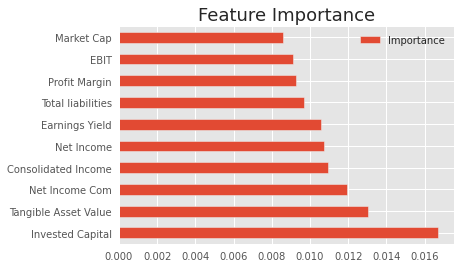

In [ ]:
top_ten_feat.plot(kind='barh')
plt.yticks(np.arange(10), top_ten_feat["Features"].values)
plt.title('Feature Importance', fontsize=18)
plt.show()

According to the Random Forest Classifier, the following features are the most important in predicting whether or not a stock is worth selling. 

1. **Tangible Asset Value:** "are physical and measurable assets that are used in a company's operations. Assets like property, plant, and equipment, are tangible assets. They form the backbone of a company's business by providing the means to which companies produce their goods and services. However, tangible assets can be damaged by naturally occurring incidence since they are physical assets." (via Investopedia)

2. **Earnings Yield:** "refers to the earnings per share for the most recent 12-month period divided by the current market price per share. The earnings yield (which is the inverse of the P/E ratio) shows the percentage of a company's earnings per share." (via Investopedia)

3. **Total Assets:** total of resources "with economic value that an individual, corporation, or country owns or controls with the expectation that it will provide a future benefit."  (via Investopedia)


### Sector Insights

First I will create a barplot with the number of counts of each sector to gain an understanding of the sector distirbution in the dataset.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


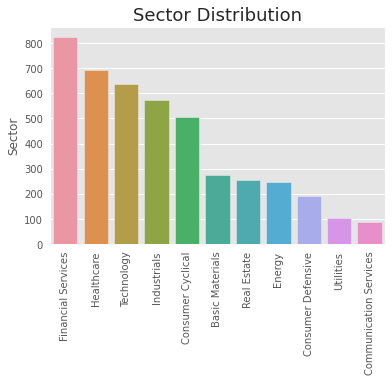

In [ ]:
sectors = sec_df2['Sector'].value_counts()
sector_len = sectors.shape[0]
sns.color_palette("Paired")
sns.barplot(np.arange(sector_len), sectors)
sector_ind = sectors.index.values.tolist()
plt.xticks(np.arange(sector_len), sector_ind, rotation=90)
plt.title('Sector Distribution', fontsize=18)
plt.show()

From this plot I can see that the most popular sectors in the dataset are the following:

1. Financial Services
2. Healthcare
3. Technology.

While the least popular sectors in the dataset are the following:

1. Communication Services
2. Ultilites
3. Consumer Defensive

I would like the gain an understanding of the class distribution of these different secttors so I will create a stacked bar plot.

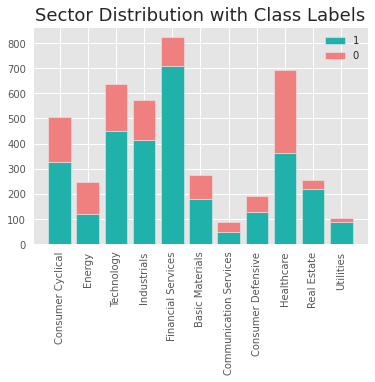

In [ ]:
sec_col = sec_df2['Sector'].unique()

neg_count = {}
pos_count = {}

for el in sec_col:
  neg_count[el] = 0
  pos_count[el] = 0

for count, row in enumerate(sec_df2['Sector']):
  if df['Class'][count] == 0:
    neg_count[row] += 1
  else:
    pos_count[row] += 1

neg = []
pos = []

for k in neg_count:
  neg.append(neg_count[k])

for k in pos_count:
  pos.append(pos_count[k])

# plot bars in stack manner
plt.bar(sec_col, pos, color="lightseagreen")
plt.bar(sec_col, neg, bottom=pos, color="lightcoral")
plt.xticks(rotation=90)
plt.legend(["1","0"])
plt.title('Sector Distribution with Class Labels', fontsize=18)
plt.show()

It seems that there are definetly some sectors which have a higher percetnage of "1" class stocks than others. To better visualize this, I can use a seaborn cat plot.

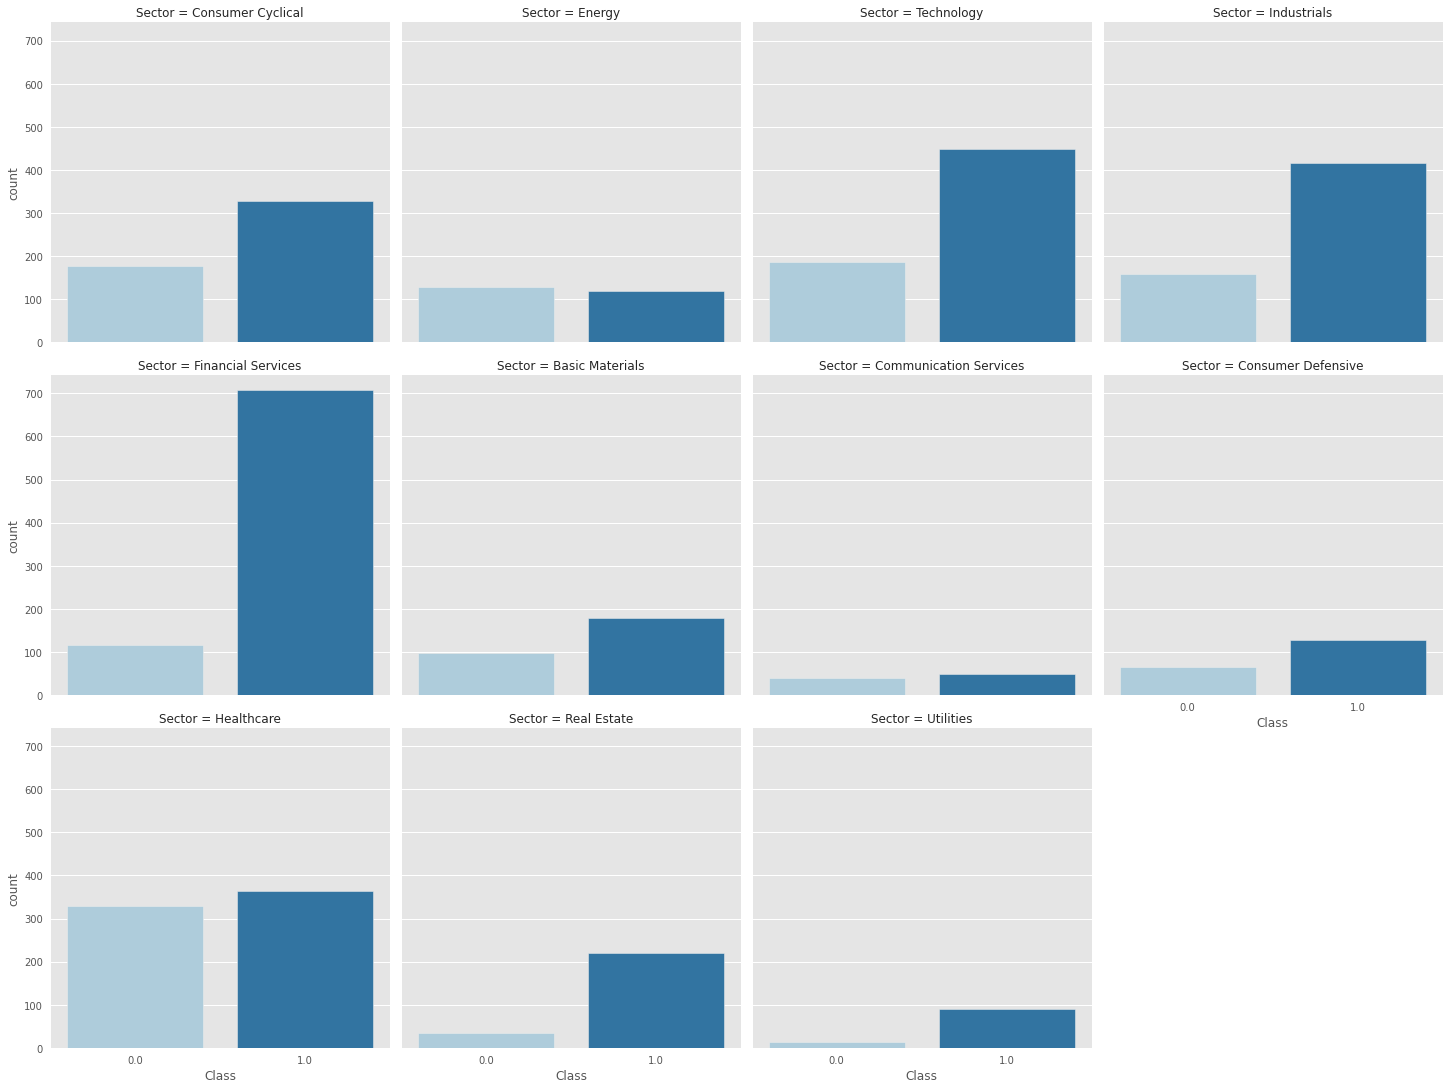

In [ ]:
sec_df = pd.concat([sec_df2, df["Class"]], axis=1)
g = sns.catplot(x="Class", col='Sector', col_wrap=4,
                data=sec_df,
                kind="count", palette="Paired")

From Figure 8, we can see the sectors that have the highest ration of stocks worth buying per stock are the following:

1. Financial Services
2. Real Estate
3. Industrials